In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import calendar
import os
from urllib.request import urlretrieve

In [2]:
def rsi(series, period):
    delta = series.diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(period).mean()
    RS_down = down_days.rolling(period).mean()
    return 100-100/(1+RS_up/RS_down)

In [6]:
def prep_df():
    #download data if not already present
    url = 'http://www.cryptodatadownload.com/cdd/Kraken_BTCUSD_d.csv'
    filename = 'Kraken_BTCUSD_d.csv'

    if not os.path.exists(filename):
        urlretrieve(url, filename)

    df = pd.read_csv('Kraken_BTCUSD_d.csv', header = 1)

    #reverse row order to make time in the oldest to newest direction
    df = df.reindex(index=df.index[::-1]).reset_index()

    #convert date from str to dt
    df.date = pd.to_datetime(df.date)

    #add columns for day of week & month of year
    df['dow_num'] = pd.to_datetime(df.date).dt.dayofweek
    df['dow_str'] = pd.to_datetime(df.date).dt.day_name()
    df['moy_num'] = pd.to_datetime(df.date).dt.month
    df['moy_str'] = pd.to_datetime(df.date).dt.month_name()
    
    #add SMA columns
    df['SMA_50'] = df.iloc[:,8].rolling(window=50).mean()
    df['SMA_100'] = df.iloc[:,8].rolling(window=100).mean()
    df['SMA_200'] = df.iloc[:,8].rolling(window=200).mean()
    #add EMA columns
    df['EMA_50'] = df.iloc[:,8].ewm(span=50,adjust=False).mean()
    df['EMA_100'] = df.iloc[:,8].ewm(span=100,adjust=False).mean()
    df['EMA_200'] = df.iloc[:,8].ewm(span=200,adjust=False).mean()
    
    #add rsi rating
    df['rsi'] = rsi(df.high, 14)

    return df

In [8]:
df = prep_df()
df.tail()

,index,id,unix,date,symbol,open,high,low,close,vwap,...,dow_str,moy_num,moy_str,SMA_50,SMA_100,SMA_200,EMA_50,EMA_100,EMA_200,rsi
2620,4,581707,1.607386e+09,2020-12-08,BTC/USD,19182.5,19300.0,18120.0,18320.5,18726.4,...,Tuesday,12,December,16201.016,13518.257,11830.7425,16510.375111,14570.284127,12619.032711,48.819212
2621,3,581708,1.607472e+09,2020-12-09,BTC/USD,18313.1,18640.0,17649.9,18548.5,18215.7,...,Wednesday,12,December,16333.478,13587.173,11877.5920,16590.301577,14649.060679,12678.032386,43.669254
2622,2,581709,1.607558e+09,2020-12-10,BTC/USD,18548.4,18557.2,17911.1,18245.5,18230.7,...,Thursday,12,December,16442.128,13650.360,11925.2440,16655.211319,14720.277299,12733.430073,47.296189
2623,1,581710,1.607645e+09,2020-12-11,BTC/USD,18246.4,18285.0,17572.0,18031.5,17917.9,...,Friday,12,December,16543.076,13716.706,11970.9110,16709.183425,14785.846066,12786.147187,57.976563
2624,0,581711,1.607731e+09,2020-12-12,BTC/USD,18031.5,18274.0,18024.0,18274.0,18154.1,...,Saturday,12,December,16649.776,13797.645,12018.0725,16770.548780,14854.918421,12840.752688,54.040064


In [9]:
#slice by time
cut_in_date='2017'
cut_off_date='2021'
plot_df = df[(df.date > cut_in_date) & (df.date < cut_off_date)]

Text(0, 0.5, '$USD Daily High')

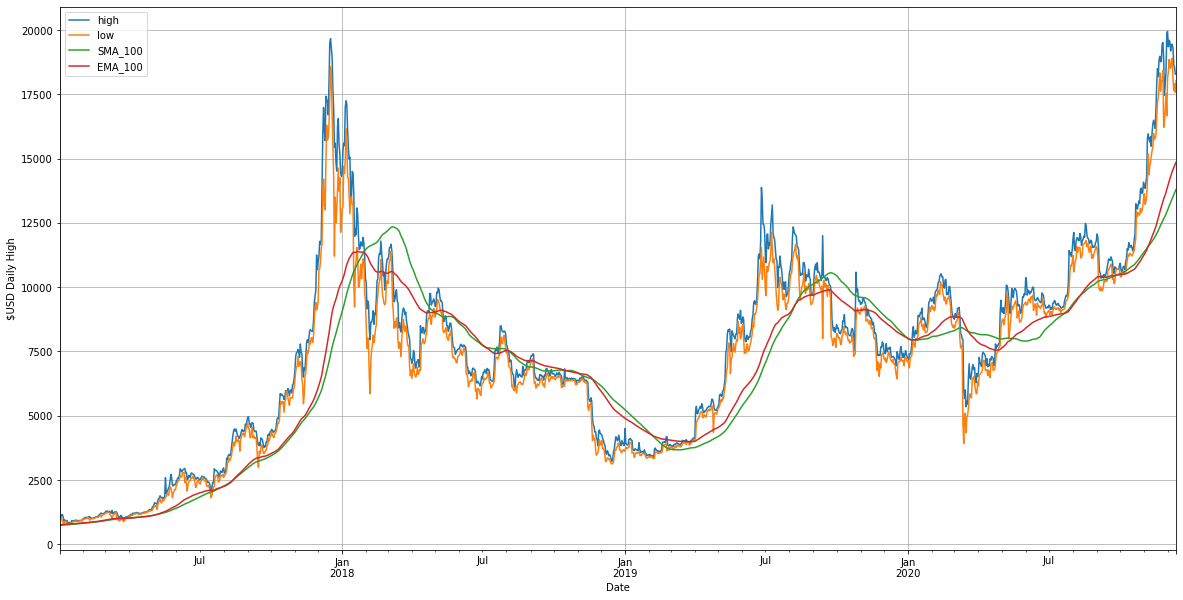

In [10]:
#Inspect the timeseries of high daily price

#plot SMAs
#ax = plot_df.plot(x='date', y=['high', 'low', 'SMA_50', 'SMA_100', 'SMA_200'], figsize=(20,10), grid=True)

#plot EMAs
#ax = plot_df.plot(x='date', y=['high', 'low', 'EMA_50', 'EMA_100', 'EMA_200'], figsize=(20,10), grid=True)

#plot 50s
#ax = plot_df.plot(x='date', y=['high', 'low', 'SMA_50', 'EMA_50'], figsize=(20,10), grid=True)
#plot 100s
ax = plot_df.plot(x='date', y=['high', 'low', 'SMA_100', 'EMA_100'], figsize=(20,10), grid=True)
#plot 200s
#ax = plot_df.plot(x='date', y=['high', 'low', 'SMA_200', 'EMA_200'], figsize=(20,10), grid=True)
#plot all
#ax = plot_df.plot(x='date', y=['high', 'low', 'SMA_50', 'SMA_100', 'EMA_50', 'EMA_100', 'EMA_200'], figsize=(20,10), grid=True)

ax.set_xlabel("Date")
ax.set_ylabel("$USD Daily High")

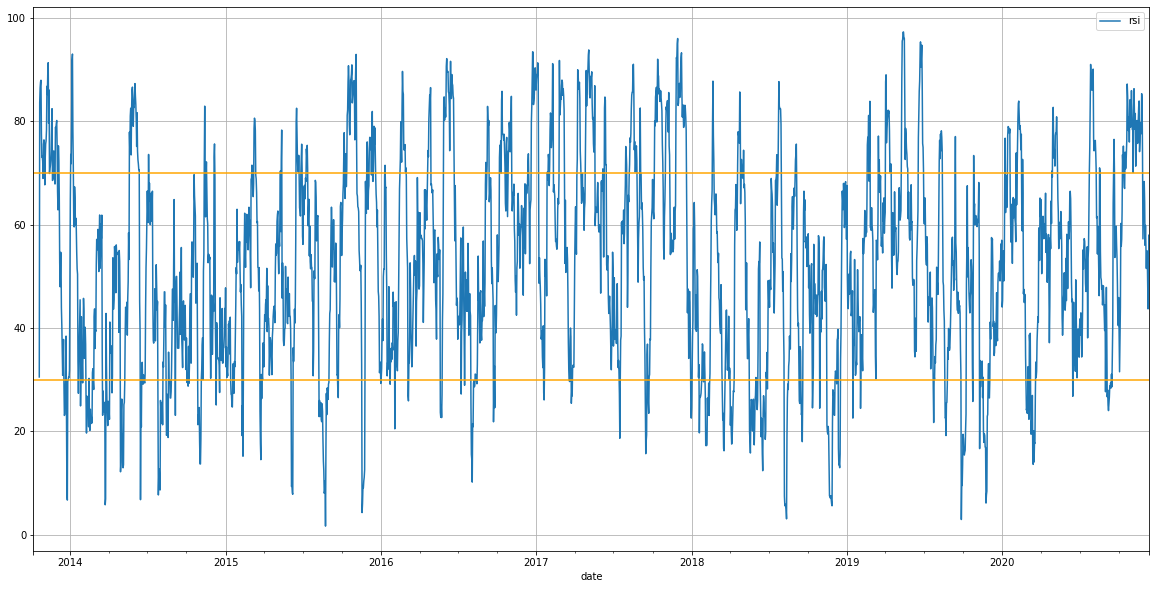

In [11]:
#Plot the RSI
ax = df.plot(x='date', y=['rsi'], figsize=(20,10), grid=True)
Plot threshold lines
plt.axhline(30, color="orange")
plt.axhline(70, color="orange")

Text(0, 0.5, 'USD')

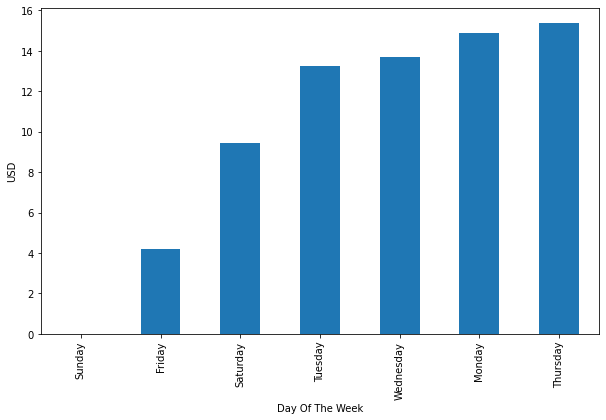

In [84]:
#get the difference in mean value for each day of the week
dow = df.groupby(['dow_str']).mean()['high']
#minus the base amount to leave the difference between lowest mean value and higher mean values
dow = dow-dow.min()
#plot
dow_ax = dow.sort_values().plot.bar(figsize=(10,6))
dow_ax.set_xlabel("Day Of The Week")
dow_ax.set_ylabel("USD")

#note: Sunday is mean lowest and Thursday is mean highest

Text(0, 0.5, 'USD')

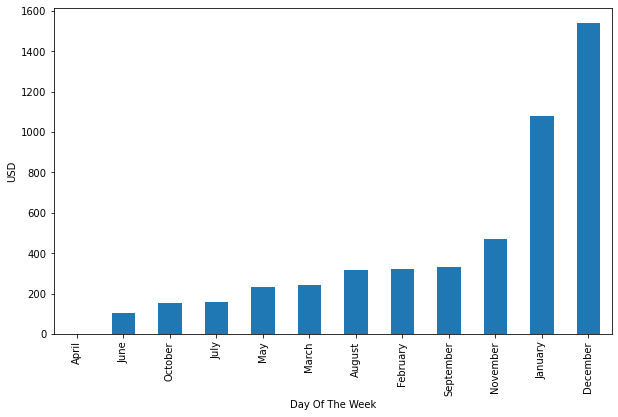

In [85]:
#get the difference in mean value for each month of the year
moy = df.groupby(['moy_str']).mean()['high']

#minus the base amount to leave the difference between lowest mean value and higher mean values
moy = moy-moy.min()

moy_ax = moy.sort_values().plot.bar(figsize=(10,6))
moy_ax.set_xlabel("Day Of The Week")
moy_ax.set_ylabel("USD")

#note: March / April is mean lowest and November is mean highest

In [12]:
#Create empty heatmap for displaying day of week and month of year
days_in_week = 7
months_in_year = 12

day_names = [calendar.day_name[i] for i in range(days_in_week)] 
month_names = [calendar.month_name[i] for i in range(1, 13)] 

btc_heatmap = pd.DataFrame(np.zeros((days_in_week, months_in_year)) , index=day_names, columns=month_names )

#add day of week (DOW) and month of year (MOY) means to heatmap

#iterate over the columns (months)
for month, weekdays in btc_heatmap.iteritems(): 
    #iterate over the rows (weekdays)
    for day, value in weekdays.iteritems():
        #add value to each cell
        btc_heatmap.at[day, month] = df[(df.moy_str == month) & (df.dow_str == day)]['high'].mean()

#round up the values to int
btc_heatmap = btc_heatmap.astype(int)

btc_heatmap

,January,February,March,April,May,June,July,August,September,October,November,December
Monday,4276,3584,3263,3512,3912,4250,4847,4994,4749,4271,5373,4546
Tuesday,4281,3709,3250,3276,4085,4371,4805,4873,4702,4487,4958,4904
Wednesday,4273,3747,3148,3282,4256,4255,4713,4902,4817,4325,5143,4971
Thursday,3957,3699,3375,3446,4301,4169,4540,5165,4591,4351,5319,4982
Friday,3840,3641,3400,3232,4158,4400,4509,5057,4614,4365,5103,5304
Saturday,3803,3910,3340,3163,4016,4625,4375,5059,4769,4425,4963,5255
Sunday,3872,3702,3279,3401,4064,4442,4413,4901,4921,4149,5139,4934


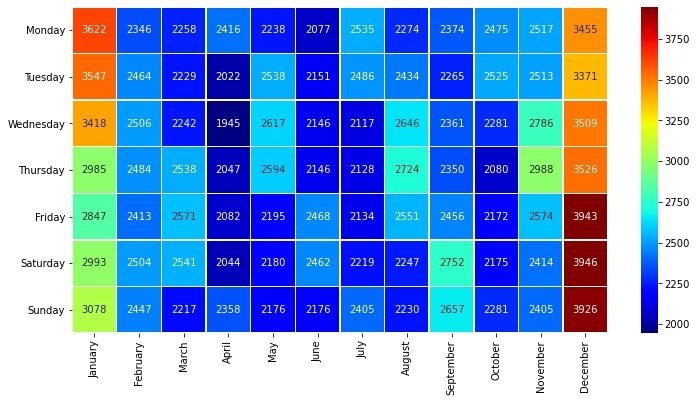

In [90]:
#plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
#format the plot
sb.heatmap(btc_heatmap, annot=True, fmt="d", linewidths=.5, cmap='jet')
plt.show()

#note: lowest mean is Wed in Mar
#note: highest mean is Mon in Dec
#note: Clear pattern of lower values in Feb & Mar
#note: Clear patter of higher values in Nov & Dec

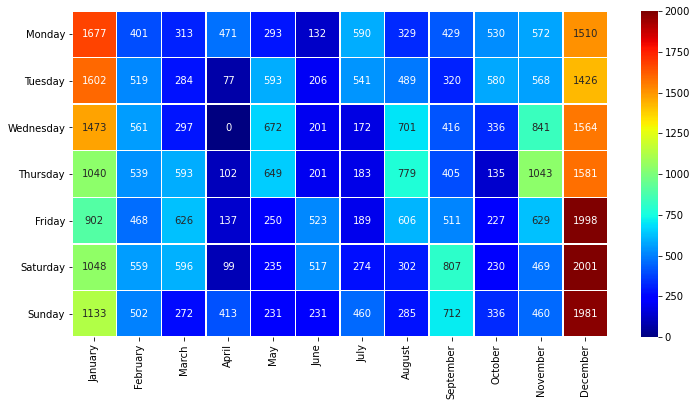

In [91]:
#Show RELATIVE difference in price
#iterate over the columns (months)
for month, weekdays in btc_heatmap.iteritems(): 
    #iterate over the rows (weekdays)
    for day, value in weekdays.iteritems():
        #add value to each cell
        btc_heatmap.at[day, month] = df[(df.moy_str == month) & (df.dow_str == day)]['high'].mean()

#round up the values to int
btc_heatmap = btc_heatmap.astype(int)
btc_heatmap = btc_heatmap - btc_heatmap.values.min()

#plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
#format the plot
sb.heatmap(btc_heatmap, annot=True, fmt="d", linewidths=.5, cmap='jet')
plt.show()